In [1]:
!nvidia-smi

Sun May  9 04:12:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /drive/MyDrive/snek/

ls: cannot access '/drive/MyDrive/snek/': No such file or directory


In [ ]:
!mkdir data
# !mkdir models

model_loc = './drive/MyDrive/snek/effnet_models/'

!cp './drive/MyDrive/snek/datasets/train_small_10_cropped.tar.gz' ./data

!tar -xvf ./data/train_small_10_cropped.tar.gz -C ./data/

## Imports

In [4]:
!pip install efficientnet_pytorch

In [ ]:
import os
import copy
import torch
import random
import pickle
import argparse
import torchvision
import numpy as np
import torch.nn as nn

import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.checkpoint as cp

from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
MODEL_DIR = './drive/MyDrive/snek/effnet_models/'
METRIC_DIR = './drive/MyDrive/snek/metrics/'
DATASET_PATH = "./data/data/train_cropped/"

In [ ]:
def load_dataset(root,
                 batchsize,
                 input_size,
                 crop_size,
                 validation_split=.2,
                 shuffle_dataset=True,
                 random_seed=42,
                 num_workers=2):

    data_path = root
    trainTransform  = torchvision.transforms.Compose([torchvision.transforms.Resize((input_size, input_size)),
                        torchvision.transforms.CenterCrop(crop_size),
                        torchvision.transforms.ToTensor(),
                        transforms.Normalize([0.0432, 0.0554, 0.0264], [0.8338, 0.8123, 0.7803]),
                        ])

    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=trainTransform
    )

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batchsize,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=num_workers)

    return train_loader, valid_loader

In [ ]:
num_epochs = 9
batch_size = 8
model_name = "efficientnet-b5"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device: {}".format(device))

Using device: cuda:0


In [ ]:
model = EfficientNet.from_pretrained(model_name)
image_size = EfficientNet.get_image_size(model_name)

Loaded pretrained weights for efficientnet-b5


In [ ]:
data = datasets.ImageFolder(DATASET_PATH)
num_classes = len(data.classes)

print("Number of classes: {}".format(num_classes))

Number of classes: 10


In [ ]:
train_loader, valid_loader = load_dataset(DATASET_PATH, batch_size, image_size, image_size)

dataloaders_dict = {
    "train": train_loader,
    "valid": valid_loader
}

In [ ]:
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

# Loss Funciton
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    loss_train_evo=[]
    acc_train_evo=[]
    fs_train_evo=[]
    
    loss_val_evo=[]
    acc_val_evo=[]
    fs_val_evo=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            fscore = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # inputs, labels = inputs.cuda(), labels.cuda()
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                Fscore = f1_score(labels_cpu, predictions_cpu, average='macro')
                fscore.append(Fscore)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            

            epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) * batch_size)
            epoch_fscore = np.average(np.array(fscore))

            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_fscore))

            MODEL_PATH = os.path.join(MODEL_DIR, model_name + "_model_{}.pt".format(epoch))
            OPTIM_PATH = os.path.join(MODEL_DIR, model_name + "_optim_{}.pt".format(epoch))
            torch.save(model.state_dict(), MODEL_PATH)
            torch.save(optimizer.state_dict(), OPTIM_PATH)
            
            if phase == 'train':
                FILENAME = METRIC_DIR +'train/'+ f"metrics_{epoch}.pkl"
                loss_train_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_train_evo.append(epoch_acc)
                fs_train_evo.append(epoch_fscore)                
            else:
                FILENAME = METRIC_DIR +'valid/'+ f"metrics_{epoch}.pkl"
                loss_val_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_val_evo.append(epoch_acc)
                fs_val_evo.append(epoch_fscore)
            
            save_metric = {
                "preds": predictions_cpu,
                "acc": epoch_acc,
                "loss": epoch_loss,
                "fscore": epoch_fscore
            }
            with open(FILENAME, "wb") as fil:
                pickle.dump(save_metric, fil)
                
            if phase == 'valid' and epoch_fscore > best_fscore:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, loss_train_evo, acc_train_evo, fs_train_evo, loss_val_evo, acc_val_evo, fs_val_evo

In [ ]:
model_ft, loss_train, acc_train, fs_train, loss_val, acc_val, fs_val = train_model(model,
                                                                                   dataloaders_dict,
                                                                                   criterion,
                                                                                   optimizer,
                                                                                   model_name,
                                                                                   num_epochs=num_epochs)

Epoch 1/9



train Loss: 0.8539 Acc: 0.7300 F: 0.632



valid Loss: 0.4536 Acc: 0.8433 F: 0.764
Epoch 2/9



train Loss: 0.4247 Acc: 0.8548 F: 0.785



valid Loss: 0.4019 Acc: 0.8583 F: 0.781
Epoch 3/9



train Loss: 0.3016 Acc: 0.8989 F: 0.843



valid Loss: 0.4329 Acc: 0.8677 F: 0.801
Epoch 4/9



train Loss: 0.2302 Acc: 0.9234 F: 0.877



valid Loss: 0.4606 Acc: 0.8650 F: 0.794
Epoch 5/9



train Loss: 0.1853 Acc: 0.9393 F: 0.903



valid Loss: 0.5504 Acc: 0.8450 F: 0.763
Epoch 6/9



train Loss: 0.1630 Acc: 0.9476 F: 0.916



valid Loss: 0.4834 Acc: 0.8770 F: 0.814
Epoch 7/9



train Loss: 0.1357 Acc: 0.9536 F: 0.928



valid Loss: 0.5971 Acc: 0.8683 F: 0.796
Epoch 8/9



train Loss: 0.1149 Acc: 0.9615 F: 0.939



valid Loss: 0.4793 Acc: 0.8767 F: 0.815
Epoch 9/9



train Loss: 0.1029 Acc: 0.9654 F: 0.945



valid Loss: 0.5466 Acc: 0.8740 F: 0.806


In [ ]:
def plot_metric(metric_train, metric_val, title):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle(title)
    ax.set(xlabel='epoch')
    ax.plot(metric_train, label='Training')
    ax.plot(metric_val, label='Validation')
    ax.legend(loc='upper left')
    plt.savefig(title + "_metric.png")

# plot_metric(loss_train, loss_val, 'Loss')
# plot_metric(acc_train, acc_val, 'Accuracy')
# plot_metric(fs_train, fs_val, 'F-Score')

# torch.save(loss_train, "loss_train.pkl")
# torch.save(loss_val, "loss_val.pkl")
# torch.save(acc_train, "acc_train.pkl")
# torch.save(acc_val, "acc_val.pkl")
# torch.save(fs_train, "fs_train.pkl")
# torch.save(fs_val, "fs_val.pkl")

In [ ]:
!zip -r efficientnet_saved_models.zip models/

In [ ]:
!zip -r efficientnet_saved_output.zip *png *pkl

In [ ]:
# !cp *zip '/gdrive/My Drive/Semester 8/CV/snek/models/'
!cp *png './drive/MyDrive/snek/plots/'

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_fscore = []
valid_fscore = []

for fil in os.listdir(METRIC_DIR + 'train/'):
    if fil == "metrics_0.pkl":
        continue
    with open(METRIC_DIR + 'train/' + fil, "rb") as f:
        temp = pickle.load(f)
    train_loss.append(temp['loss'])
    train_acc.append(temp['acc'])
    train_fscore.append(temp['fscore'])

for fil in os.listdir(METRIC_DIR + 'valid/'):
    with open(METRIC_DIR + 'valid/' + fil, "rb") as f:
        temp = pickle.load(f)
    valid_loss.append(temp['loss'])
    valid_acc.append(temp['acc'])
    valid_fscore.append(temp['fscore'])

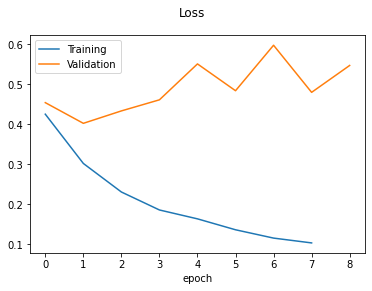

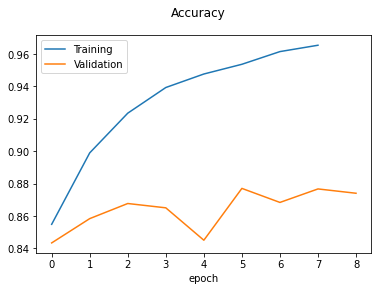

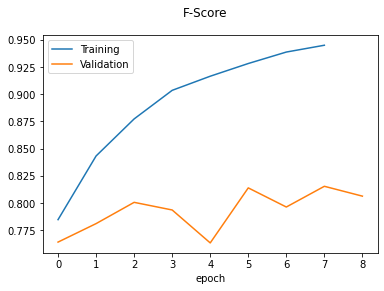

In [ ]:
plot_metric(train_loss, valid_loss, 'Loss')
plot_metric(train_acc, valid_acc, 'Accuracy')
plot_metric(train_fscore, valid_fscore, 'F-Score')

In [ ]:
train_acc.insert(0, 0.63)

## Streamlit check

In [5]:
! pip install streamlit

ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.4 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [22]:
!python app.py

2021-05-09 04:21:31.145 WARNING root: 
  command:

    streamlit run app.py [ARGUMENTS]


In [26]:
! streamlit run app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.86.49.63:8501

  Stopping...
  Stopping...


In [20]:
%cd .//drive/MyDrive/snek/

/content/drive/.shortcut-targets-by-id/1m_ToZdCqLgdpK6QGW7SSfSxYKJQdGGyi/snek


In [21]:
!ls

app.py		   densenet.ipynb      metrics	snek
crop_images.ipynb  efficientnet.ipynb  models	Untitled0.ipynb
datasets	   effnet_models       plots
